In [1]:
import seaborn as sns
import pylab as rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib 
import pandas as pd 
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
from  sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping

2023-10-31 23:04:32.699808: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-31 23:04:32.719133: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-31 23:04:32.719159: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-31 23:04:32.719176: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-31 23:04:32.723925: I tensorflow/core/platform/cpu_feature_g

In [2]:
df=pd.read_csv('/home/j/usfq/tesis/StockPredictionModels/Data/Complete.csv')
df

,Date,ticker_symbol,p_sentiment,Open,High,Low,Close,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,AAPL,0.857156,27.847500,27.860001,26.837500,27.332500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
1,2015-01-02,AMZN,0.731959,15.629000,15.737500,15.348000,15.426000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
2,2015-01-02,GOOG,0.883473,26.378078,26.490770,26.133251,26.168653,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
3,2015-01-02,GOOGL,0.908735,26.629999,26.790001,26.393999,26.477501,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
4,2015-01-02,MSFT,0.804051,46.660000,47.419998,46.540001,46.759998,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7531,2019-12-30,AMZN,0.748412,93.699997,94.199997,92.030998,92.344498,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7532,2019-12-30,GOOG,0.676151,67.500000,67.650002,66.700996,66.806999,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7533,2019-12-30,GOOGL,0.705876,67.840500,67.849998,66.891998,66.985497,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7534,2019-12-30,MSFT,0.762997,158.990005,159.020004,156.729996,157.589996,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651


In [3]:
#turn date into unix time
#df['Date'] = pd.to_datetime(df['Date'])
#df['Date'] = df['Date'].apply(lambda x: x.timestamp())
#df

In [4]:
#generate new dataframes for each ticker_symbol
df_dict={}
for key in df['ticker_symbol'].unique():
    df_dict[key]=df[df['ticker_symbol']==key]
    df_dict[key]=df_dict[key].drop(columns=['ticker_symbol'])
    df_dict[key]=df_dict[key].sort_values(by=['Date']).reset_index(drop=True)
    #df_dict[key]=df_dict[key].drop(columns=['Date'])
    print(key,df_dict[key].shape)
    print(df_dict[key].head(-1))

AAPL (1252, 17)
            Date  p_sentiment       Open       High        Low      Close  \
0     2015-01-02     0.857156  27.847500  27.860001  26.837500  27.332500   
1     2015-01-05     0.744531  27.072500  27.162500  26.352501  26.562500   
2     2015-01-06     0.769826  26.635000  26.857500  26.157499  26.565001   
3     2015-01-07     0.773995  26.799999  27.049999  26.674999  26.937500   
4     2015-01-08     0.770458  27.307501  28.037500  27.174999  27.972500   
...          ...          ...        ...        ...        ...        ...   
1246  2019-12-20     0.775477  70.557503  70.662498  69.639999  69.860001   
1247  2019-12-23     0.759453  70.132500  71.062500  70.092499  71.000000   
1248  2019-12-24     0.742264  71.172501  71.222504  70.730003  71.067497   
1249  2019-12-26     0.670220  71.205002  72.495003  71.175003  72.477501   
1250  2019-12-27     0.760582  72.779999  73.492500  72.029999  72.449997   

      unrate  psr       m2    dspic      pce    reer       

In [5]:
ticker='TSLA'

In [6]:
df=df_dict[ticker].copy()
df.head()

,Date,p_sentiment,Open,High,Low,Close,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,0.741818,14.858000,14.883333,14.217333,14.620667,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
1,2015-01-05,0.646626,14.303333,14.433333,13.810667,14.006000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
2,2015-01-06,0.696584,14.004000,14.280000,13.614000,14.085333,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
3,2015-01-07,0.654833,14.223333,14.318667,13.985333,14.063333,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
4,2015-01-08,0.615611,14.187333,14.253333,14.000667,14.041333,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811


In [7]:
#putting the close column on the last position
df=df[['Date',
'p_sentiment',
 'Open',
 'High',
 'Low',
 'unrate',
 'psr',
 'm2',
 'dspic',
 'pce',
 'reer',
 'ir',
 'ffer',
 'tcs',
 'indpro',
 'ccpi',
  'Close',]]

In [8]:
dates = pd.to_datetime(df['Date'])

In [9]:
cols=list(df)[1:]
cols

['p_sentiment',
 'Open',
 'High',
 'Low',
 'unrate',
 'psr',
 'm2',
 'dspic',
 'pce',
 'reer',
 'ir',
 'ffer',
 'tcs',
 'indpro',
 'ccpi',
 'Close']

In [10]:
df_for_training = df[cols].astype(float)

In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_for_training)

In [12]:
print(scaled_data)

[[0.78512475 0.27521525 0.24356139 ... 0.77924797 0.         0.26330631]
 [0.57178167 0.24678828 0.21948349 ... 0.77924797 0.         0.23121105]
 [0.68374619 0.23144731 0.21127918 ... 0.77924797 0.         0.23535347]
 ...
 [0.47142104 0.97577552 0.99347221 ... 0.57323507 1.         1.        ]
 [0.38496901 1.         1.         ... 0.57323507 1.         0.99805053]
 [0.44112774 0.97878229 0.97749165 ... 0.57323507 1.         0.9434678 ]]


In [13]:
#split scaled data into training, val and testing
#train_data=scaled_data[0:1000,:]
#val_data=scaled_data[1000:1125,:]
#test_data=scaled_data[1125:,:]

In [14]:
n_future = 1 # Number of days we want to predict into the future
n_past = 7 # Number of past days we want to use to predict the future

In [15]:
X=[]
y=[]
for i in range(n_past, len(scaled_data) - n_future +1):
    X.append(scaled_data[i - n_past:i, 0:df_for_training.shape[1]])
    y.append(scaled_data[i + n_future - 1:i + n_future, len(cols)-1])

In [16]:
#shape of X_s and y_s
X, y = np.array(X), np.array(y)
print(X.shape)
print(y.shape)

(1250, 7, 16)
(1250, 1)


In [17]:
X_train=X[0:1125,:]
X_test=X[1125:,:]
X_val=X_train[1000:1125,:]
y_train=y[0:1125,:]
y_test=y[1125:,:]
y_val=y_train[1000:1125,:]


#early stopping


Epoch 1/100
6/6 [==============================] - 1s 44ms/step - loss: 0.1027 - val_loss: 0.0666
Epoch 2/100
6/6 [==============================] - 0s 15ms/step - loss: 0.0991 - val_loss: 0.0637
Epoch 3/100
6/6 [==============================] - 0s 16ms/step - loss: 0.0957 - val_loss: 0.0610
Epoch 4/100
6/6 [==============================] - 0s 14ms/step - loss: 0.0922 - val_loss: 0.0583
Epoch 5/100
6/6 [==============================] - 0s 14ms/step - loss: 0.0889 - val_loss: 0.0557
Epoch 6/100
6/6 [==============================] - 0s 14ms/step - loss: 0.0857 - val_loss: 0.0532
Epoch 7/100
6/6 [==============================] - 0s 13ms/step - loss: 0.0826 - val_loss: 0.0508
Epoch 8/100
6/6 [==============================] - 0s 14ms/step - loss: 0.0796 - val_loss: 0.0485
Epoch 9/100
6/6 [==============================] - 0s 13ms/step - loss: 0.0767 - val_loss: 0.0463
Epoch 10/100
6/6 [==============================] - 0s 14ms/step - loss: 0.0738 - val_loss: 0.0441
Epoch 11/100
6/6 [=

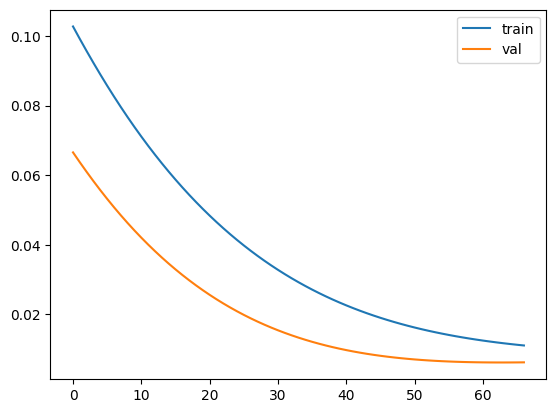

4/4 [==============================] - 0s 3ms/step
(125,)
(125,)


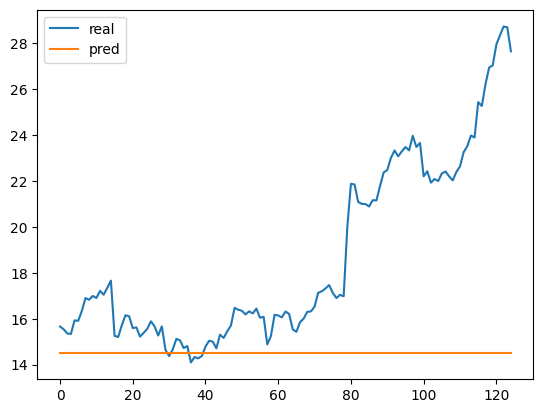

Epoch 1/100
12/12 [==============================] - 1s 23ms/step - loss: 0.0260 - val_loss: 0.0104
Epoch 2/100
12/12 [==============================] - 0s 11ms/step - loss: 0.0078 - val_loss: 0.0058
Epoch 3/100
12/12 [==============================] - 0s 11ms/step - loss: 0.0050 - val_loss: 0.0046
Epoch 4/100
12/12 [==============================] - 0s 10ms/step - loss: 0.0042 - val_loss: 0.0036
Epoch 5/100
12/12 [==============================] - 0s 11ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 6/100
12/12 [==============================] - 0s 10ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 7/100
12/12 [==============================] - 0s 10ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 8/100
12/12 [==============================] - 0s 10ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 9/100
12/12 [==============================] - 0s 11ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 10/100
12/12 [==============================] - 0s 10ms/step - loss: 0.0016 - val_loss: 0.0014

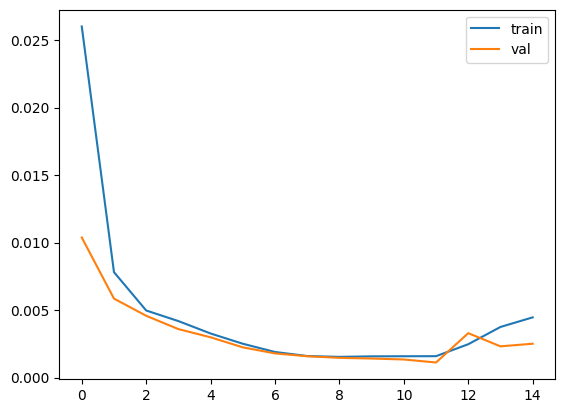

4/4 [==============================] - 0s 3ms/step
(125,)
(125,)


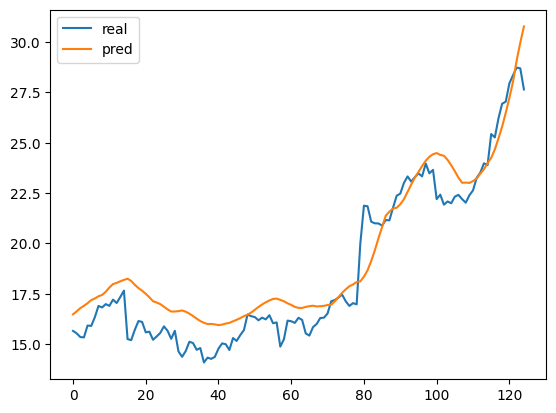

Epoch 1/100
18/18 [==============================] - 1s 17ms/step - loss: 0.0106 - val_loss: 0.0483
Epoch 2/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0083 - val_loss: 0.0510
Epoch 3/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0082 - val_loss: 0.0047
Epoch 4/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0065 - val_loss: 0.0074
Epoch 5/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0035 - val_loss: 0.0183
Epoch 6/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0040 - val_loss: 0.0046
Epoch 7/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0025 - val_loss: 0.0077
Epoch 8/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0040 - val_loss: 0.0028
Epoch 9/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0025 - val_loss: 0.0153
Epoch 10/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0041 - val_loss: 0.0062
Epoc

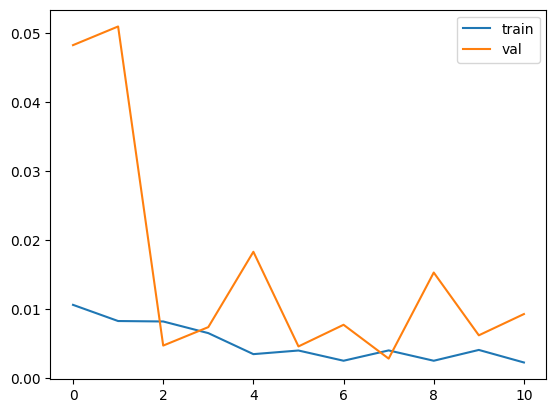

4/4 [==============================] - 0s 3ms/step
(125,)
(125,)


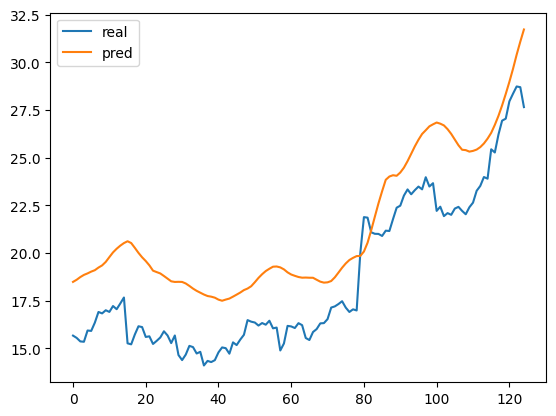

Epoch 1/100
24/24 [==============================] - 1s 15ms/step - loss: 0.0265 - val_loss: 0.1413
Epoch 2/100
24/24 [==============================] - 0s 10ms/step - loss: 0.0336 - val_loss: 0.0246
Epoch 3/100
24/24 [==============================] - 0s 11ms/step - loss: 0.0118 - val_loss: 0.0676
Epoch 4/100
24/24 [==============================] - 0s 9ms/step - loss: 0.0100 - val_loss: 0.0055
Epoch 5/100
24/24 [==============================] - 0s 9ms/step - loss: 0.0071 - val_loss: 0.0397
Epoch 6/100
24/24 [==============================] - 0s 9ms/step - loss: 0.0068 - val_loss: 0.0492
Epoch 7/100
24/24 [==============================] - 0s 9ms/step - loss: 0.0053 - val_loss: 0.0364


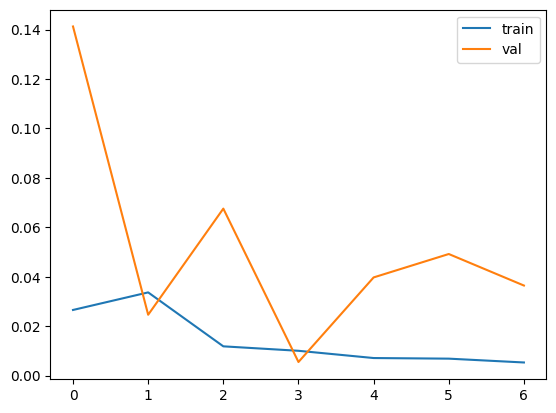

4/4 [==============================] - 0s 5ms/step
(125,)
(125,)


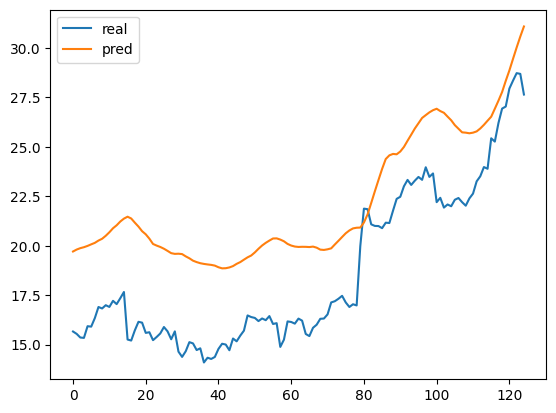

Epoch 1/100
30/30 [==============================] - 1s 15ms/step - loss: 0.0278 - val_loss: 0.0206
Epoch 2/100
30/30 [==============================] - 0s 10ms/step - loss: 0.0298 - val_loss: 0.0677
Epoch 3/100
30/30 [==============================] - 0s 10ms/step - loss: 0.0337 - val_loss: 0.0479
Epoch 4/100
30/30 [==============================] - 0s 10ms/step - loss: 0.0137 - val_loss: 0.0099
Epoch 5/100
30/30 [==============================] - 0s 9ms/step - loss: 0.0124 - val_loss: 0.0215
Epoch 6/100
30/30 [==============================] - 0s 9ms/step - loss: 0.0155 - val_loss: 0.0366
Epoch 7/100
30/30 [==============================] - 0s 9ms/step - loss: 0.0056 - val_loss: 0.0118


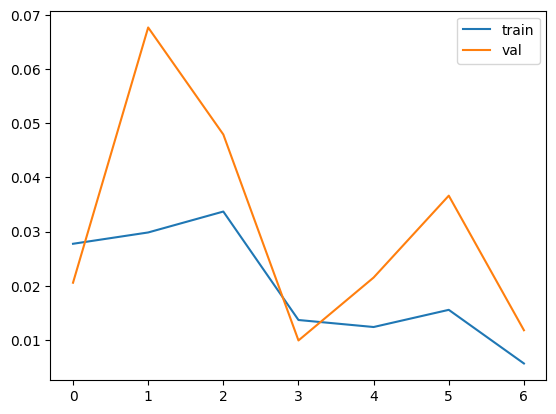

4/4 [==============================] - 0s 3ms/step
(125,)
(125,)


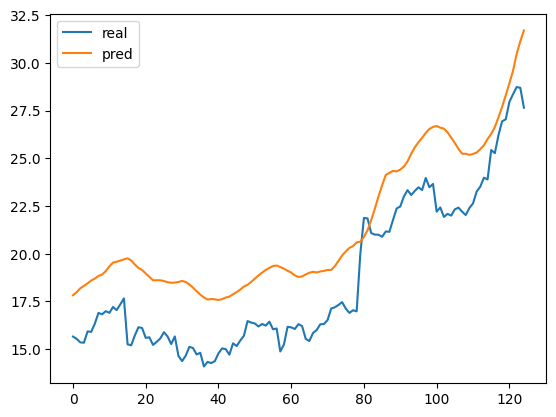

In [18]:
tscv = TimeSeriesSplit(n_splits=5)
y_test=np.repeat(y_test,16,axis=1)
y_test=scaler.inverse_transform(y_test)[:,-1] 
for train_index, val_index in tscv.split(X_train):
    early_stop=EarlyStopping(monitor='val_loss',patience=3)
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model=Sequential()
    model.add(LSTM(256,activation='relu',input_shape=(X_train.shape[1],X_train.shape[2]),return_sequences=True))
    model.add(LSTM(3,activation='relu',return_sequences=False))
    model.add(Dense(y_train.shape[1]))
    model.compile(optimizer='adam',loss='mse')
  
    history=model.fit(X_train,y_train,epochs=100,validation_data=(X_val,y_val),shuffle=False, callbacks=[early_stop])
    plt.plot(history.history['loss'],label='train')
    plt.plot(history.history['val_loss'],label='val')
    plt.legend()
    plt.show()
    y_pred=model.predict(X_test)
    y_pred.shape

    pred=np.repeat(y_pred,16,axis=1)

    pred=scaler.inverse_transform(pred)[:,-1]
    

    print(pred.shape)
    print(y_test.shape)

    #plotting the results
    plt.plot(y_test, label='real')
    plt.plot(pred, label='pred') 
    plt.legend()
    plt.show()


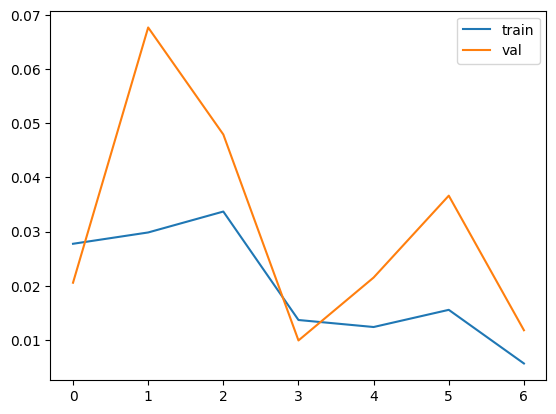

In [19]:
# plot learning curves
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [20]:
#evaluate model
